# Applied Data Science

## Projekt Gruppe 6 

Gruppenmitglieder: Reto Alexander Nüesch Erismann, Michelle Daniela Wehrli, Rebecca Sarah Baumann


# Aufgabe 2: Datenaufbereitung

In [1]:
#!pip install tensorflow
#!pip install pandas
#!pip install numpy
#!pip install matplotlib

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm

print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
# setup folder where you will save logs for tensorflow 
#root_logdir = os.path.join(os.curdir,"my_logs_ADS")

#def get_run_logdir():
#   import time
#   run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#   return os.path.join(root_logdir, run_id)

#run_logdir = get_run_logdir()

In [5]:
#create keras Tensorboard callbacks
#tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [6]:
#data_dir = r'C:\Users\bauma\OneDrive\Desktop\AppliedDataScience\AppliedDataScience\fruit-recognition\train\train'
#data_dir = r'C:\Users\User\OneDrive - ZHAW\GitHub\AppliedDataScience\fruit-recognition\train\train'

data_dir = 'fruit-recognition/train/train'

BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 16854 files belonging to 33 classes.
Using 13484 files for training.
Found 16854 files belonging to 33 classes.
Using 3370 files for validation.


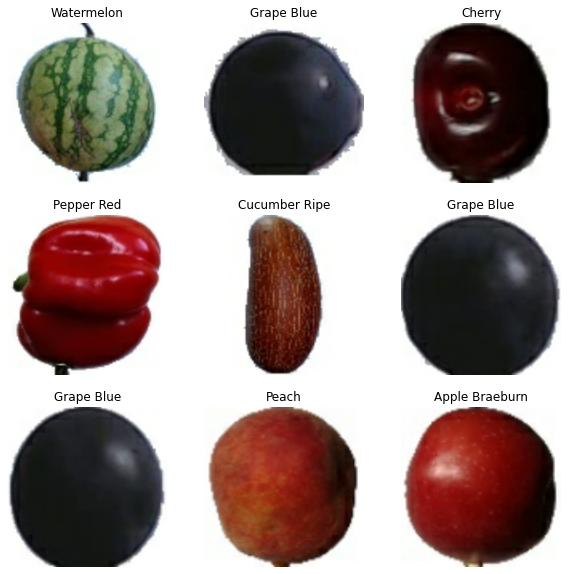

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 106
Number of test batches: 21


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        
        tf.keras.layers.RandomZoom(0.5),                    # Zoom
        tf.keras.layers.RandomFlip("horizontal"),           # Flip
        tf.keras.layers.RandomContrast(0.6),                # Contrast
        tf.keras.layers.RandomRotation(0.2),                # Rotation      
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


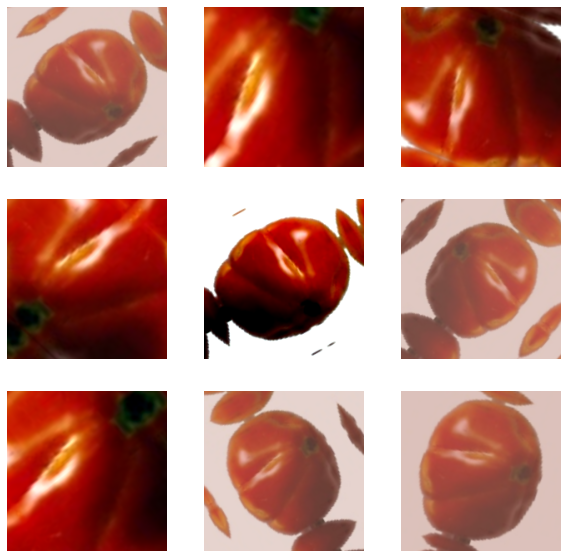

In [12]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Aufgabe 3: Modell trainieren

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [16]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 96, 96, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) #We need to set `training=False` as our model contains a `BatchNormalization` layer. More explanation here https://www.tensorflow.org/guide/keras/transfer_learning
x = tf.keras.layers.GlobalAveragePooling2D()(x) #this layer has the same purpose as tf.keras.layers.Flatten(). Need to connect something 2D to something 1D. Ask if you want to know more :)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(33, activation="softmax")(x) 
model1 = tf.keras.Model(inputs, outputs)


In [19]:
base_learning_rate = 0.0001
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 192, 192, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 192, 192, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 192, 192, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [21]:
initial_epochs = 5

loss0, accuracy0 = model1.evaluate(validation_dataset)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


106/106 [==============================] - 22s 193ms/step - loss: 4.1057 - accuracy: 0.0282


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.11
initial accuracy: 0.03


Let's now load tensorboard

In [23]:
#%load_ext tensorboard
#%tensorboard --logdir my_logs_ADS

In [24]:
#from keras.callbacks import History
#history_cbm1= tf.keras.callbacks.History()

In [25]:
history = model1.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

#                   ,callbacks=[history_cbm1])

Epoch 1/5
422/422 [==============================] - 126s 294ms/step - loss: 2.4996 - accuracy: 0.3474 - val_loss: 1.2766 - val_accuracy: 0.7846
Epoch 2/5
422/422 [==============================] - 125s 295ms/step - loss: 1.0436 - accuracy: 0.7665 - val_loss: 0.6334 - val_accuracy: 0.9157
Epoch 3/5
422/422 [==============================] - 124s 294ms/step - loss: 0.6240 - accuracy: 0.8769 - val_loss: 0.4024 - val_accuracy: 0.9484
Epoch 4/5
422/422 [==============================] - 124s 293ms/step - loss: 0.4542 - accuracy: 0.9105 - val_loss: 0.2889 - val_accuracy: 0.9638
Epoch 5/5
422/422 [==============================] - 124s 294ms/step - loss: 0.3547 - accuracy: 0.9312 - val_loss: 0.2235 - val_accuracy: 0.9700


In [27]:
#!pip install pyyaml h5py

In [28]:
# Save the model as SavedModel1
#!mkdir -p saved_model1

In [29]:
#model1.save('saved_model/my_model')
# Content of the folder
#ls saved_model1/my_model

Alternativer Startpunkt, wenn gespeichertes Model verwendet werden soll.

In [30]:
#model1=tf.keras.models.load_model(«my_amazing_model.h5»)

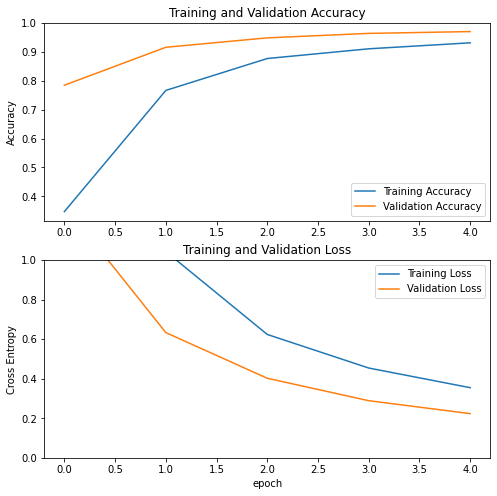

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

 Fine Tuning

In [32]:
base_model.trainable = True

In [33]:
earlystopping_cb  = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [37]:
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 192, 192, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 192, 192, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 192, 192, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [42]:
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model1.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

# callbacks=[tensorboard_cb]


Epoch 5/6
422/422 [==============================] - 172s 407ms/step - loss: 0.1063 - accuracy: 0.9671 - val_loss: 0.0217 - val_accuracy: 0.9955
Epoch 6/6
422/422 [==============================] - 170s 404ms/step - loss: 0.0719 - accuracy: 0.9792 - val_loss: 0.0225 - val_accuracy: 0.9947


In [43]:
# Save the model as SavedModel2
#!mkdir -p saved_model2
#model2.save('saved_model2/mymodel')
# Content of the folder
#ls saved_model2/my_model

# Aufgabe 4: Validierung des Modells

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

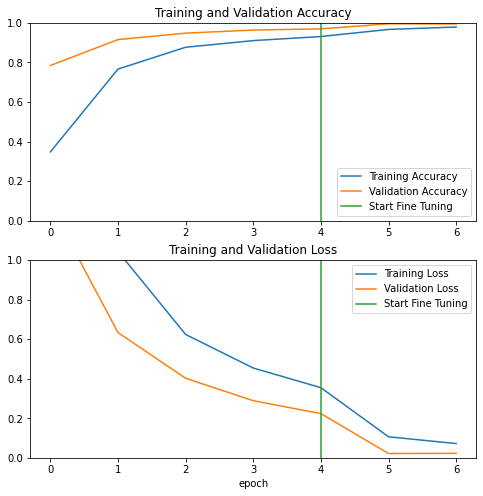

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and Prediction

In [47]:
loss, accuracy = model1.evaluate(test_dataset)
print('Test accuracy :', accuracy)

21/21 [==============================] - 4s 188ms/step - loss: 0.0216 - accuracy: 0.9970
Test accuracy : 0.9970238208770752


Predictions:
 [0 0 0 ... 0 0 0]
Labels:
 [ 6  5  4 22  7 25  9 18  4 12 14 16 10 30 22 30 22 15 27 24 18 25 21 27
 23 24 17 12 31 12 25  8]


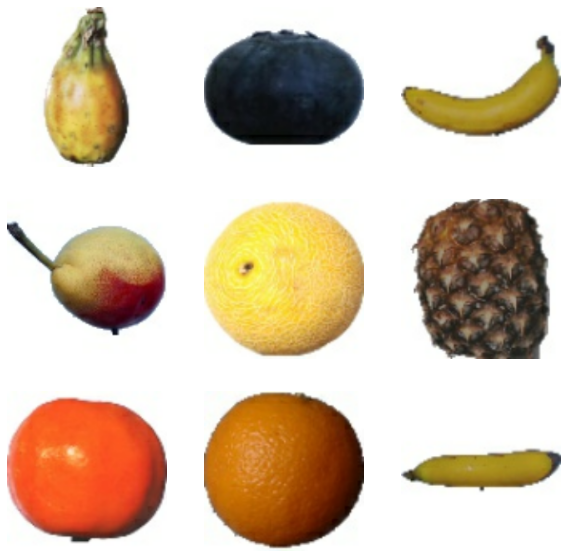

In [52]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model1.predict_on_batch(image_batch).flatten()

#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")   
    

# Aufgabe 5: Bildklassifizierung - Anwendung des Modells